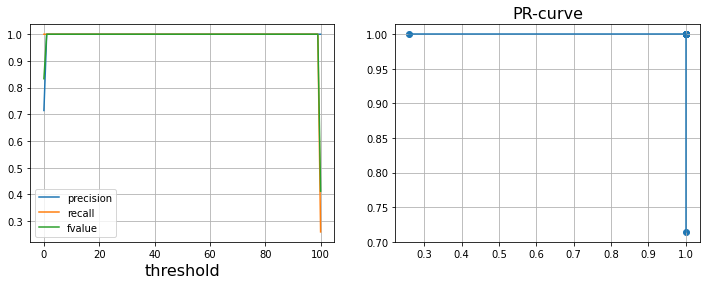

[(0.0, 0.714, 1.0), (0.01, 1.0, 1.0), (0.02, 1.0, 1.0), (0.03, 1.0, 1.0), (0.04, 1.0, 1.0), (0.05, 1.0, 1.0), (0.06, 1.0, 1.0), (0.07, 1.0, 1.0), (0.08, 1.0, 1.0), (0.09, 1.0, 1.0)]
bestThreshold=0.5


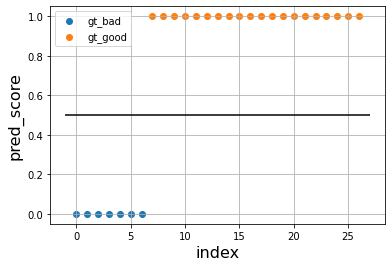

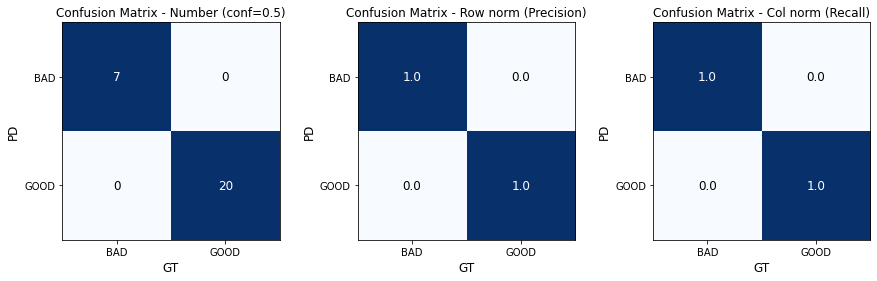

In [132]:
import glob, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

bdL = sorted( glob.glob("../_data/mam/eval/bad/*.png") )
gdL = sorted( glob.glob("../_data/mam/eval/good/*.png") )
lbL = [0]*len(bdL)+[1]*len(gdL)
result = np.load("../experiments/multimodal/cats_vs_dogs/class_0/model/o_test_finetuned_samples_likelihood.npy")
sigmoid = lambda z: 1/(1+math.e**(-z)) if z>-750 else 0

# P/R/PR curve
precisionL, recallL, fvalueL = [], [], []
for threshold in range(101):
    M = np.zeros((2,2))
    for i,score in zip(lbL, result):
        j = int(sigmoid(score)>0.01*threshold)
        M[i][j]+=1
    precisionL.append( M[0][0]/M[0,:].sum() ) 
    recallL.append( M[0][0]/M[:,0].sum() )
    fvalueL.append( 2*precisionL[-1]*recallL[-1]/(precisionL[-1]+recallL[-1]) if precisionL[-1]+recallL[-1] else 0 )
plt.figure(figsize=(6*2,4))
plt.subplot(1,2,1)
plt.plot(precisionL)
plt.plot(recallL)
plt.plot(fvalueL)
plt.grid('on')
plt.legend(labels=["precision","recall","fvalue"])
plt.xlabel("threshold", fontsize=16)
plt.subplot(1,2,2)
plt.title("PR-curve", fontsize=16)
plt.plot(recallL, precisionL)
plt.scatter(recallL, precisionL)
plt.grid('on')
plt.show()
print( [ (i*0.01,round(precisionL[i*10],3),round(recallL[i*10],3)) for i in range(10) ] )

# get best threshold
strategy = "recall"
if strategy=="precision":
    maxp = max([ p for p,r in zip(precisionL,recallL) if r>0.5 ])
    idxL = [ i for i in range(101) if precisionL[i]==maxp ]
    bestThreshold = idxL[len(idxL)//2] * 0.01
elif strategy=="recall":
    maxr = max([ r for p,r in zip(precisionL,recallL) if p>0.5 ])
    idxL = [ i for i in range(101) if recallL[i]==maxr ]
    bestThreshold = idxL[len(idxL)//2] * 0.01
elif strategy=="fvalue":
    maxf = max(fvalueL)
    idxL = [ i for i in range(101) if fvalueL[i]==maxf ]
    bestThreshold = idxL[len(idxL)//2] * 0.01
else:
    raise
print(f"bestThreshold={bestThreshold}")

# plot distribution
plt.scatter( range(len(bdL)), [ sigmoid(x) for x in result[:len(bdL)] ] )
plt.scatter( range(len(bdL),len(lbL)), [ sigmoid(x) for x in result[len(bdL):len(lbL)] ] )
plt.hlines(bestThreshold, -1, len(lbL), color="black")
plt.xlabel("index", fontsize=16)
plt.ylabel("pred_score", fontsize=16)
plt.legend(labels=["gt_bad","gt_good"])
plt.grid('on')
plt.show()

# confusion
M = np.zeros((2,2))
for i,score in zip(lbL, result):
    j = int(sigmoid(score)>bestThreshold)
    M[i][j]+=1
#print("confusion_matrix:\n", M)
axis0sum = M.sum(axis=0)
N = M.copy()
for i in range(len(N)):
    if axis0sum[i] != 0:
        N[:,i] /= axis0sum[i]
#print(N)
axis1sum = M.sum(axis=1)
P = M.copy()
for i in range(len(P)):
    if axis1sum[i] != 0:
        P[i,:] /= axis1sum[i]
#print(M)
plt.figure(figsize=(5*3,4))
# fig1 - number
fig = plt.subplot(1,3,1)
plt.title(f"Confusion Matrix - Number (conf={0.5})", fontsize=12)
plt.xlabel("GT", fontsize=12)
plt.ylabel("PD", fontsize=12)
fig.set_xticks([0,1]) # values
fig.set_xticklabels(['BAD','GOOD']) # labels
fig.set_yticks([0,1]) # values
fig.set_yticklabels(['BAD','GOOD']) # labels
plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
# fig2 - precision
fig = plt.subplot(1,3,2)
plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
plt.xlabel("GT", fontsize=12)
plt.ylabel("PD", fontsize=12)
fig.set_xticks([0,1]) # values
fig.set_xticklabels(['BAD','GOOD']) # labels
fig.set_yticks([0,1]) # values
fig.set_yticklabels(['BAD','GOOD']) # labels
plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        plt.text(j, i, round(P[i][j],3), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
# fig3 - recall
fig = plt.subplot(1,3,3)
plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
plt.xlabel("GT", fontsize=12)
plt.ylabel("PD", fontsize=12)
fig.set_xticks([0,1]) # values
fig.set_xticklabels(['BAD','GOOD']) # labels
fig.set_yticks([0,1]) # values
fig.set_yticklabels(['BAD','GOOD']) # labels
plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        plt.text(j, i, round(N[i][j],3), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
#plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
#plt.savefig(f"{self.savePath}/confusion.jpg")
plt.show()

In [134]:
result

array([-2.09860343e+05, -2.09860343e+05, -9.95823592e+02, -4.38658354e+02,
       -1.94231864e+03, -9.15780948e+02, -6.63239462e+02,  1.79764105e+01,
        1.82049437e+01,  1.79776378e+01,  1.70228005e+01,  1.83796712e+01,
        1.42914842e+01,  1.88758527e+01,  1.99817861e+01,  1.93864911e+01,
        1.50743670e+01,  1.67553527e+01,  1.81975724e+01,  1.97115507e+01,
        1.55602164e+01,  1.61445371e+01,  1.69394720e+01,  1.78154731e+01,
        1.96969641e+01,  1.59284434e+01,  1.75401787e+01])